# Análisis Exploratorio de Datos (Exploratory Data Analysis, EDA)

## Revisión y depuración de los datos


Se realiza un análisis exploratorio de los datos para poder identificar las distribuciones de los datos, correlaciones y variabilidad del mismo. Con base a lo anterior se realiza lo siguiente:
1. Identificación y Manejo de valores faltantes
2. Manejo de multicolinealidad
3. Manejo de valores atípicos

Logrando obtener un conjunto de datos "limpio" donde se ha eliminado valores atípicos, columnas irrelevantes y se ha tratado a los valores nulos. 

In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional, List, Tuple
import phik


def plot_boxplots(df: pd.DataFrame, target_col: str):
    """
    Genera boxplots agrupados para comparar la distribución de columnas numéricas
    en el universo, la clase 1 y la clase 2.
    """
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    if not numerical_cols:
        print("No se encontraron columnas numéricas.")
        return

    if target_col not in df.columns or df[target_col].nunique() < 2:
        print(f"La columna '{target_col}' no es válida o no tiene al menos dos clases.")
        return

    unique_labels = df[target_col].unique()
    label1, label2 = unique_labels[0], unique_labels[1]
    
    n_cols = 3
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(numerical_cols):
        # Obtener los datos para cada grupo
        data_full = df[col].dropna()
        data_label1 = df[df[target_col] == label1][col].dropna()
        data_label2 = df[df[target_col] == label2][col].dropna()
        
        ax = axes[i]
        
        # Posiciones de los boxplots
        positions = [1, 2.5, 4]
        colors = ['midnightblue', 'palegreen', 'lightsteelblue']
        
        # Graficar los boxplots en el mismo eje
        bp = ax.boxplot([data_full, data_label1, data_label2],
                        positions=positions,
                        widths=0.6,
                        patch_artist=True,  # Permite colorear los cuadros
                        manage_ticks=True)
        
        # Asignar colores a los boxplots
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            
        ax.set_title(f'Distribución de {col}')
        ax.set_xticks(positions)
        ax.set_xticklabels(['Universo', f'Clase {label1}', f'Clase {label2}'])
        ax.set_ylabel(col)
        ax.grid(True)
    
    # Eliminar subplots no utilizados
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()


def plot_categoricalDistribution(df: pd.DataFrame, target_col: str):
    """
    Analiza y visualiza en gráficos de barras valores categóricos del universo y las dos clases.
    """
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if not categorical_cols:
        print("No se encontraron columnas categóricas.")
        return

    if target_col not in df.columns or df[target_col].nunique() != 2:
        print(f"La columna '{target_col}' no es válida o no tiene exactamente dos clases.")
        return

    unique_labels = df[target_col].unique()
    label1, label2 = unique_labels[0], unique_labels[1]

    n_cols = 2
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        ax = axes[i]
        
        counts_full = df[col].value_counts().reset_index()
        counts_full.columns = [col, 'Recuento']
        counts_full['Grupo'] = 'Universo'
        
        counts_label1 = df[df[target_col] == label1][col].value_counts().reset_index()
        counts_label1.columns = [col, 'Recuento']
        counts_label1['Grupo'] = f'Etiqueta_{label1}'
        
        counts_label2 = df[df[target_col] == label2][col].value_counts().reset_index()
        counts_label2.columns = [col, 'Recuento']
        counts_label2['Grupo'] = f'Etiqueta_{label2}'

        df_plot = pd.concat([counts_full, counts_label1, counts_label2])
        
        sns.barplot(x=col, y='Recuento', data=df_plot, hue='Grupo', ax=ax,
                    palette={'Universo': 'midnightblue', 
                             f'Etiqueta_{label1}': 'palegreen', 
                             f'Etiqueta_{label2}': 'lightsteelblue'})
        
        ax.set_title(f'Distribución de {col} por Grupo')
        ax.set_xlabel(col)
        ax.set_ylabel('Recuento')
        ax.tick_params(axis='x', rotation=45)
        plt.setp(ax.get_xticklabels(), ha='right')
        ax.grid(True)
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()



def plot_missingValues(df: pd.DataFrame, target_col: str):
    """
    Analiza y visualiza en subplots el porcentaje de valores nulos para las columnas que los contienen.
    """
    cols_with_missing_values = df.columns[df.isnull().any()].tolist()
    
    cols_to_analyze = [col for col in cols_with_missing_values if col != target_col]

    if not cols_to_analyze:
        print("El DataFrame no contiene columnas con valores nulos para analizar, excluyendo la columna de etiqueta.")
        return

    if target_col not in df.columns or df[target_col].nunique() < 2:
        print(f"La columna '{target_col}' no es válida o no tiene al menos dos clases.")
        return

    unique_labels = df[target_col].unique()
    label1, label2 = unique_labels[0], unique_labels[1]
    
    null_percentages_full = df[cols_to_analyze].isnull().sum() / len(df) * 100
    null_percentages_label1 = df[df[target_col] == label1][cols_to_analyze].isnull().sum() / len(df[df[target_col] == label1]) * 100
    null_percentages_label2 = df[df[target_col] == label2][cols_to_analyze].isnull().sum() / len(df[df[target_col] == label2]) * 100

    n_cols = 3
    n_rows = (len(cols_to_analyze) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()
    
    color_palette = {'Universo': 'midnightblue', 
                     f'Clase_{label1}': 'palegreen', 
                     f'Clase_{label2}': 'lightsteelblue'}

    for i, col in enumerate(cols_to_analyze):
        ax = axes[i]
        
        data_for_plot = pd.DataFrame({
            'Grupo': ['Universo', f'Clase_{label1}', f'Clase_{label2}'],
            'Porcentaje de nulos': [null_percentages_full.loc[col], 
                                     null_percentages_label1.loc[col], 
                                     null_percentages_label2.loc[col]]
        })

        sns.barplot(x='Grupo', y='Porcentaje de nulos', data=data_for_plot, ax=ax, palette=color_palette, hue='Grupo', legend=False)
        
        ax.set_title(f'Nulos en {col}')
        ax.set_xlabel('')
        ax.set_ylabel('Porcentaje de nulos')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y')
        plt.setp(ax.get_xticklabels(), ha='right')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    handles = [plt.Rectangle((0,0),1,1, color=color_palette['Universo']), 
               plt.Rectangle((0,0),1,1, color=color_palette[f'Clase_{label1}']), 
               plt.Rectangle((0,0),1,1, color=color_palette[f'Clase_{label2}'])]
    labels = ['Universo', f'Clase_{label1}', f'Clase_{label2}']
    fig.legend(handles, labels, loc='upper right', title="Grupo", bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()



def plot_phiK(df: pd.DataFrame):
    """
    Calcula y grafica la matriz de correlación Phi-K (phik) de un DataFrame. También calcula
    el valor promedio de correlación phiK que tiene cada campo respecto a los demás ordenando las columnas de mayor 
    a menor valor promedio.
    Args:
        df: El DataFrame de pandas a analizar.
    """
    # Calcula la matriz de correlación Phi-K
    phiK = df.phik_matrix()

    # Crea un mapa de calor usando Seaborn
    plt.figure(figsize=(12, 10))
    sns.heatmap(phiK, annot=True, cmap='rocket_r', fmt=".2f", linewidths=.5)
    
    plt.title('Matriz de Correlación Phi-K')
    plt.xlabel('Características')
    plt.ylabel('Características')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


def impute_missing_values(df: pd.DataFrame, target_col: Optional[str] = None,
                          impute_by_class: bool = False) -> pd.DataFrame:
    """
    Imputa valores faltantes en un DataFrame, usando la mediana para columnas numéricas y la moda para categóricas.
    
    Args:
        df: DataFrame de pandas a procesar.
        target_col: La columna de etiqueta para la imputación por clase.
        impute_by_class: Si es True, imputa por la mediana/moda de cada clase.
                         Si es False, imputa por la mediana/moda del universo.

    Returns:
        Un nuevo DataFrame con los valores faltantes imputados.
    """
    df_imputed = df.copy()
    
    numerical_cols = df_imputed.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df_imputed.select_dtypes(include=['object', 'category']).columns.tolist()

    if impute_by_class and target_col:
        print(f"Imputando valores por clase usando la columna '{target_col}'.")
        for col in numerical_cols:
            df_imputed[col] = df_imputed.groupby(target_col)[col].transform(lambda x: x.fillna(x.median()))
        for col in categorical_cols:
            df_imputed[col] = df_imputed.groupby(target_col)[col].transform(lambda x: x.fillna(x.mode()[0]))
    else:
        print("Imputando valores usando los del universo (todo el dataset).")
        for col in numerical_cols:
            median_value = df_imputed[col].median()
            df_imputed[col] = df_imputed[col].fillna(median_value)
        for col in categorical_cols:
            mode_value = df_imputed[col].mode()[0]
            df_imputed[col] = df_imputed[col].fillna(mode_value)
            
    return df_imputed

In [92]:
from sklearn.datasets import fetch_openml
from pyspark.sql import SparkSession

# Descargar desde OpenML
data = fetch_openml("credit-approval", version=1, as_frame=True)
df_pandas = data.frame  

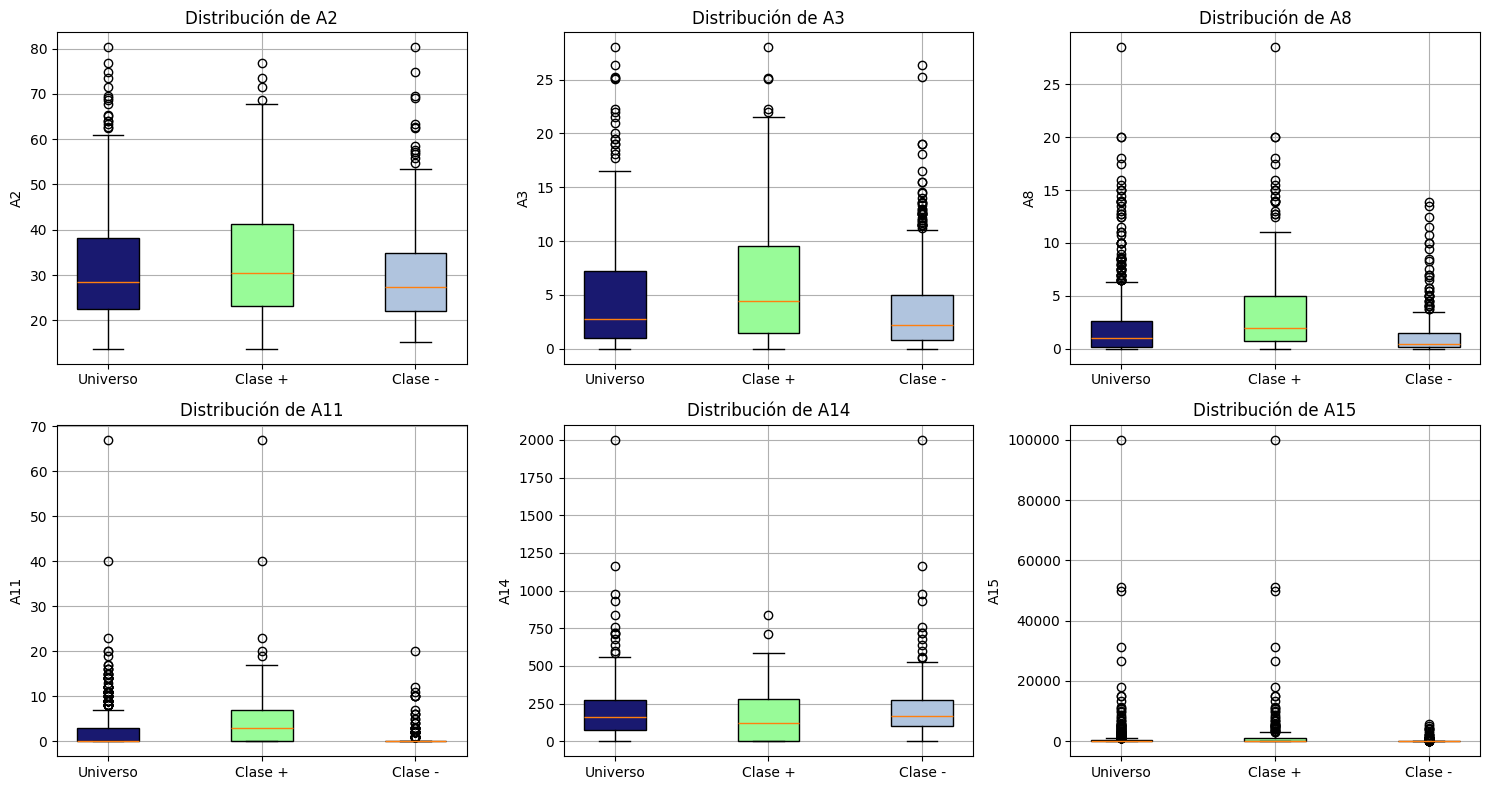

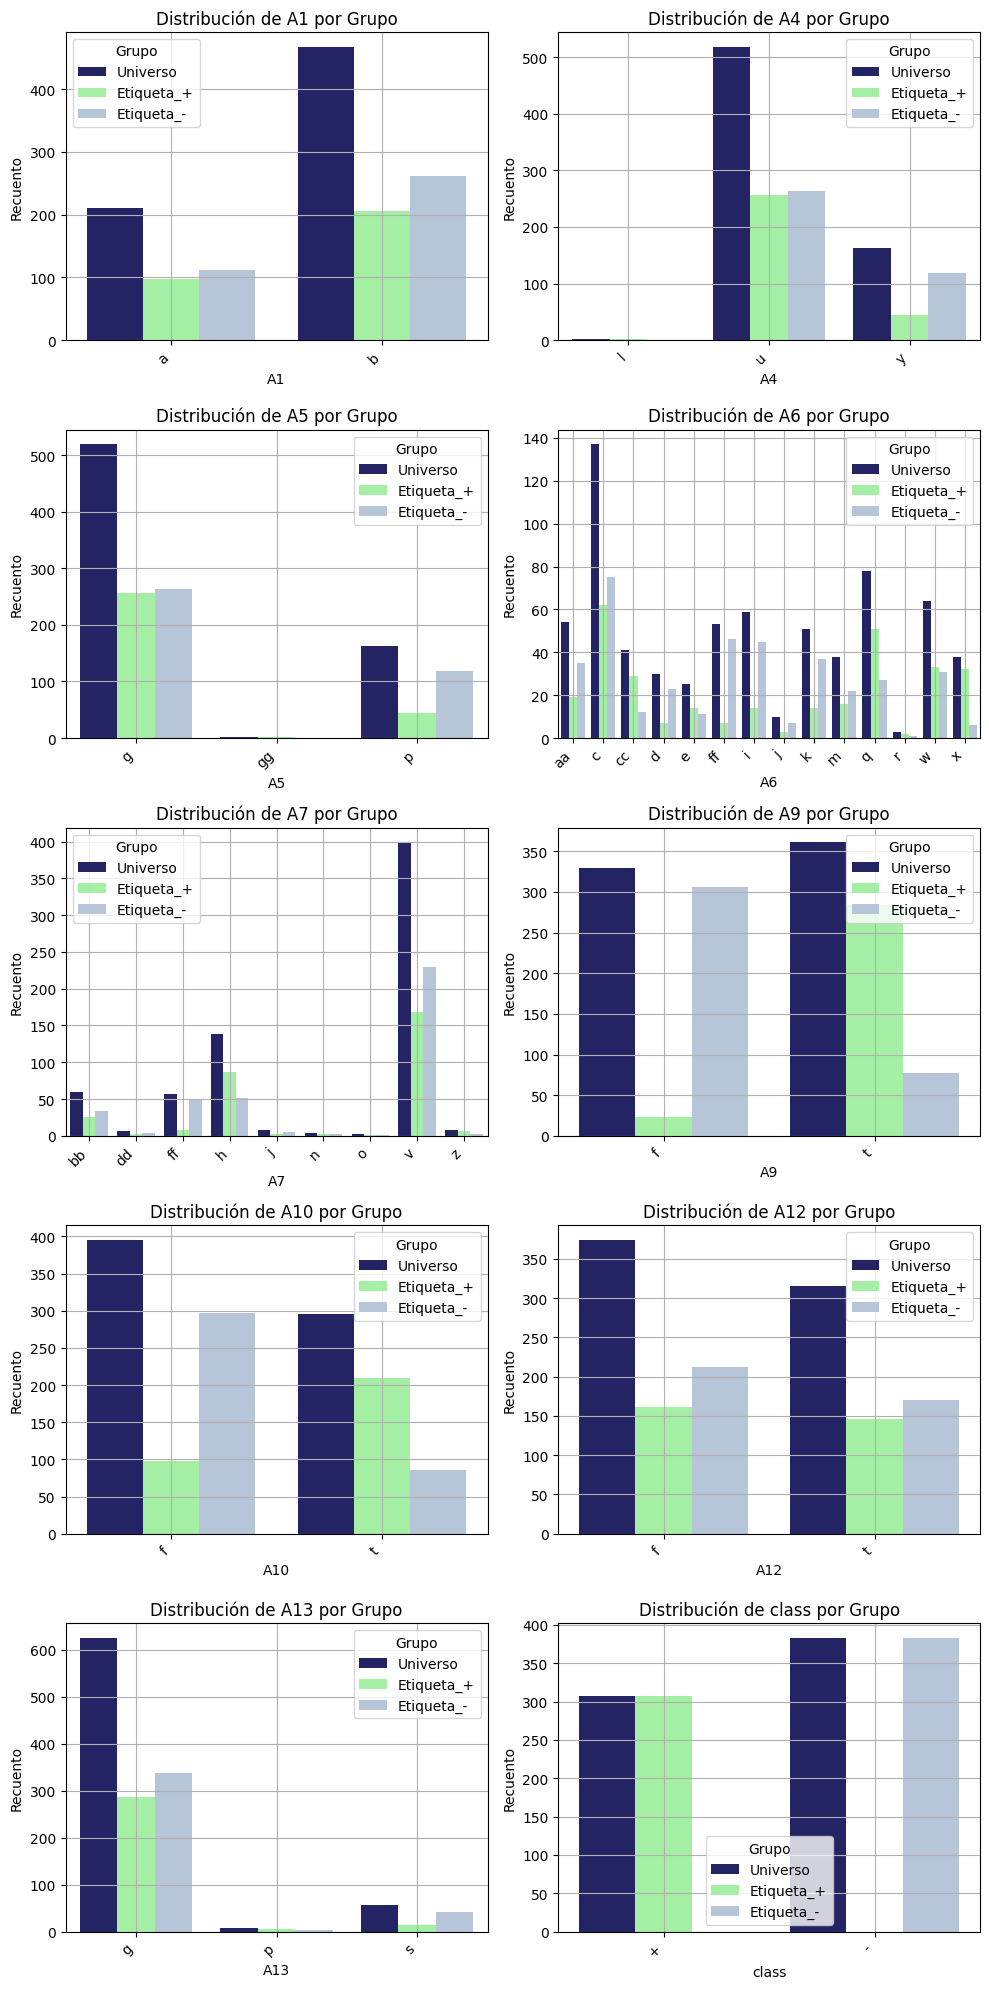

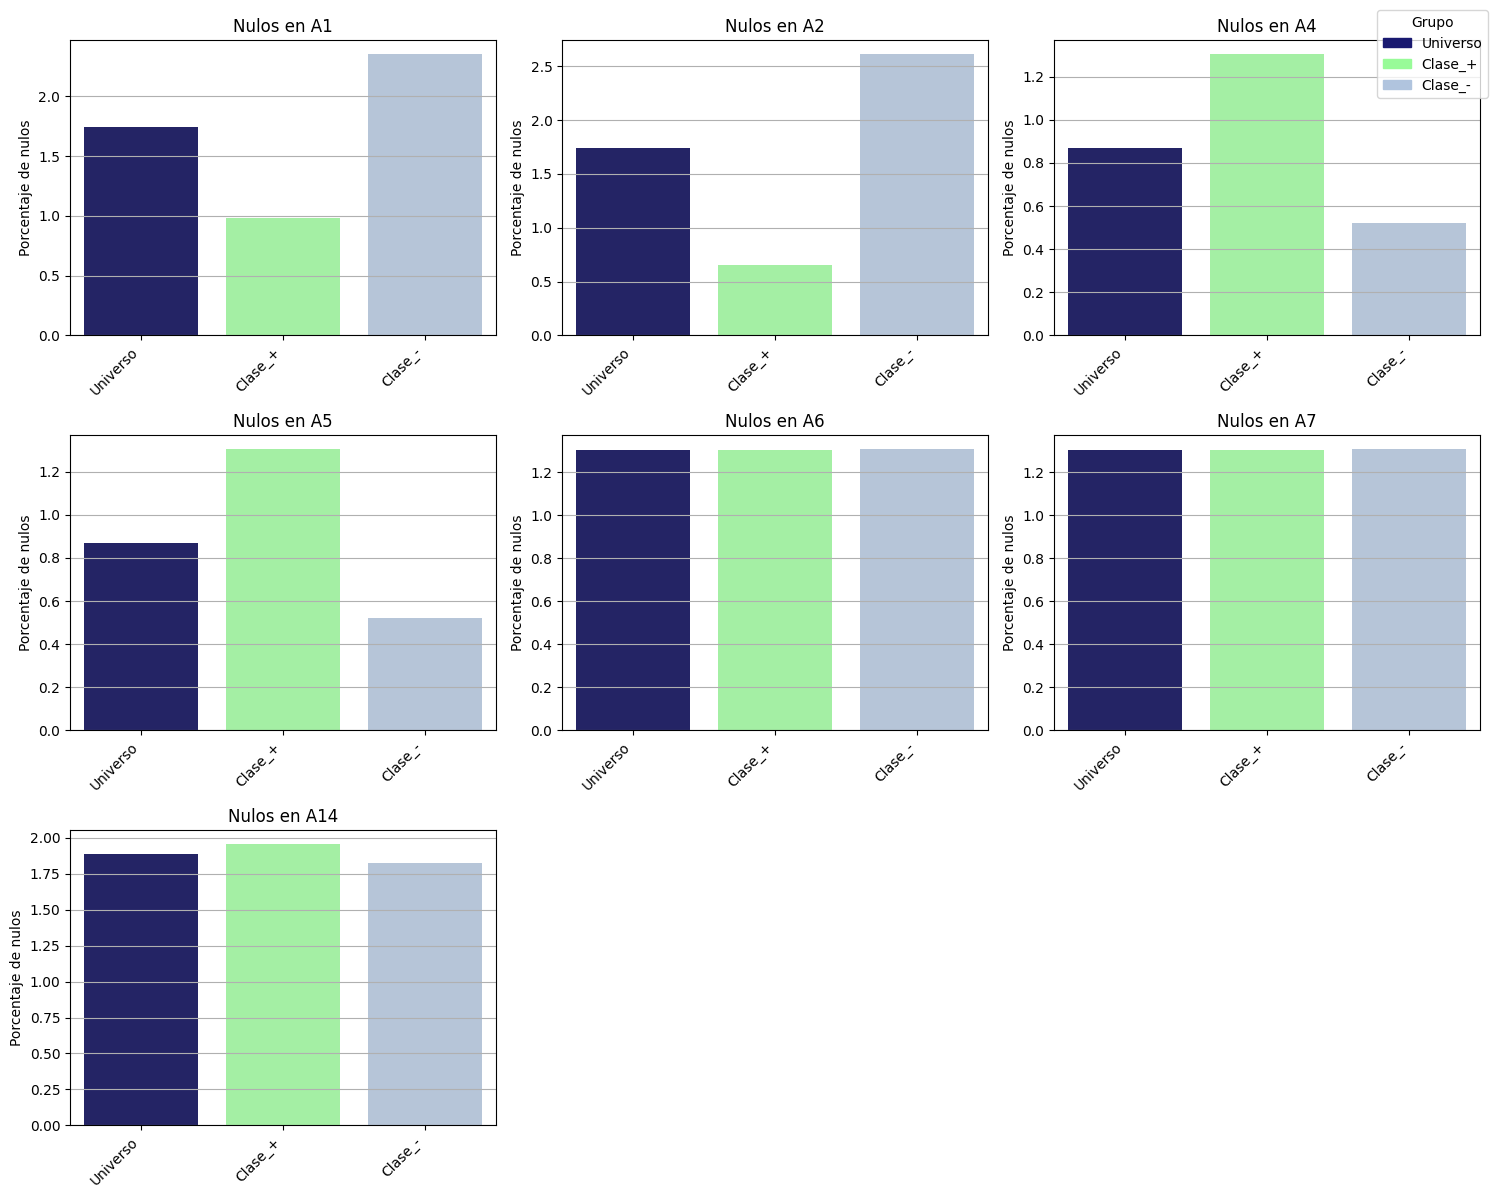

In [93]:
plot_boxplots(df_pandas, 'class')
plot_categoricalDistribution(df_pandas, 'class')
plot_missingValues(df_pandas, 'class')

In [95]:
df_pandas2 = impute_missing_values(df_pandas, 'class')

Imputando valores usando los del universo (todo el dataset).


interval columns not set, guessing: ['A2', 'A3', 'A8', 'A11', 'A14', 'A15']


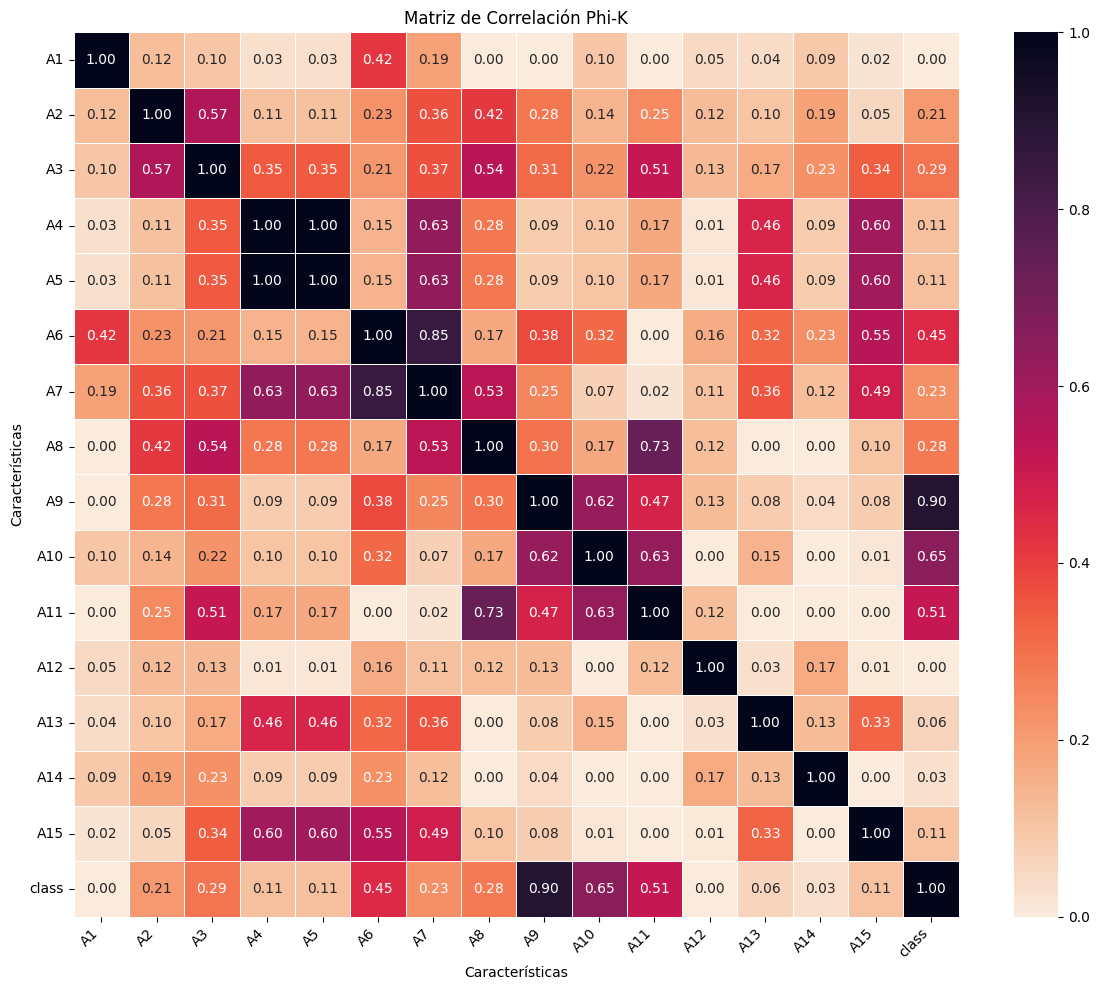

In [100]:
plot_phiK(df_pandas2)

## Conversión de los datos


Dada la naturaleza de los datos, se realiza la conversión correspondiente de las variables categóricas a numéricas. 

## Imputación de los datos


Para los valores faltantes, se escoje la mejor manera de rellenarlos.

# Experimentos con Algoritmos de Aprendizaje de Máquina (supervisado)

# Análisis de resultados

# Selección de mejor modelo

# Referencias 

M. Baak, R. Koopman, H. Snoek, S. Klous,
A new correlation coefficient between categorical, ordinal and interval variables with Pearson characteristics,
Computational Statistics & Data Analysis,
Volume 152,
2020,
